In [18]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmaps
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap
import cartopy.feature as cfea

def get_coordinate(city_index):
    # open city information text
    city_path = '/home/kajiyama/H08/H08_20230612/map/dat/cty_lst_/cityrange_list_temp.txt'
    with open(city_path, "r") as file:
        all_lines = file.readlines()
    # get city
    line = all_lines[city_index - 1]
    line = line.strip()
    parts = line.split()
    
    city_num = parts[0].zfill(3)
    city = parts[5].replace("\"", "").replace("?", "").replace("/", "")
    
    lonmin = float(parts[6])
    lonmax = float(parts[7])
    latmin = float(parts[8])
    latmax = float(parts[9])

    # Dimension of the data
    a = 2160
    b = 4320

    ### Define the latitudes and longitudes
    # West from UK is negative 0 <= lon <= -180
    # East from UK is positive 0 <= lon <= 180
    # small value to larger value (34-36, 138-140)
    lat = np.linspace(-90, 90, a+1)
    lon = np.linspace(-180, 180, b+1)

    # calculate the indices correspondignt to the desired lat and lon
    lat_start, lat_end = np.searchsorted(lat, [latmin, latmax])
    lon_start, lon_end = np.searchsorted(lon, [lonmin, lonmax])

    ### adjust to 0.25 grid
    # lat
    if lat_start%3 == 0:
        lat_start = lat_start
    elif lat_start%3 == 1:
        lat_start -= 1
    elif lat_start%3 == 2:
        lat_start += 1

    # lon
    if lon_start%3 == 0:
        lon_start = lon_start
    elif lon_start%3 == 1:
        lon_start -= 1
    elif lon_start%3 == 2:
        lon_start += 1

    # 24 grid x 24 grid
    lat_end = lat_start + 24
    lon_end = lon_start + 24

    # convert real lonlat to h08 lonlat
    latmin_gl5 = lat[lat_start]
    latmax_gl5 = lat[lat_end]
    lonmin_gl5 = lon[lon_start]
    lonmax_gl5 = lon[lon_end]
    
    return lat_start, lat_end, lon_start, lon_end, latmin_gl5, latmax_gl5, lonmin_gl5, lonmax_gl5

In [26]:
def explore_citymask(index, threshold_density=1000):
    # index=23: Jakarta
    
    #-----------------------------------------------
    # Initialization
    #-----------------------------------------------

    # map data
    MAP='CAMA'

    # 中心グリッドからの初期半径
    radius = 1

    # explore grid radius
    radius_max = 12

    #-----------------------------------------------
    # load true data (UN city list)
    #-----------------------------------------------

    pop_list = []
    name_list = []
    inf_path = '/home/kajiyama/H08/H08_20230612/map/dat/cty_lst_/city_list03.txt'
    for l in open(inf_path).readlines():
        data = l[:-1].split('	')
        pop_list.append(int(data[4]))
        name_list.append(data[5])

    #-----------------------------------------------
    # load population and ared data
    #-----------------------------------------------

    # population data(GWP4 2000)
    pop = np.fromfile('/home/kajiyama/H08/H08_20230612/map/dat/pop_tot_/C05_a___20000000.gl5', 'float32').reshape(2160, 4320)
    area = np.fromfile(f'/home/kajiyama/H08/H08_20230612/map/dat/lnd_ara_/lndara.{MAP}.gl5', 'float32').reshape(2160, 4320)

    #-----------------------------------------------
    # load city_center coordinate
    #-----------------------------------------------

    location = np.fromfile(f'/home/kajiyama/H08/H08_20230612/map/dat/cty_cnt_/city_{index:08d}.gl5','float32').reshape(2160,4320)
    x = np.where(location==1)[0]
    y = np.where(location==1)[1]
    x = x[0]
    y = y[0]
    
    #-----------------------------------------------
    # check if city center is right
    #-----------------------------------------------
    org_cnt = pop[x, y]
    circle=3
    for a in range(x-circle, x+circle+1):
        for b in range(y-circle, y+circle+1):
            candidate = pop[a, b]
            if candidate >= org_cnt:
                org_cnt = candidate
                x = a
                y = b

    #-----------------------------------------------
    #  Get city population and city name
    #-----------------------------------------------

    pop_city = pop_list[index-1]*1000
    city_name = name_list[index-1]

    #-----------------------------------------------
    #  Get area(km2) and population per grid
    #-----------------------------------------------

    A = area[x,y]/1000./1000.
    threshold = threshold_density * A

    #-----------------------------------------------
    #  Make save array
    #-----------------------------------------------

    # 保存用マスクファイル
    mask = np.zeros((2160,4320),'float32')
    mask[x,y] = 1

    # maskのコピーファイル
    f_mask = np.zeros((2160,4320),'float32')

    #-----------------------------------------------
    #  Make explore array
    #-----------------------------------------------

    # 探索用ファイル
    search_1 = np.zeros((2160,4320),'float32')
    search_1[x,y] = 1
    search_2 = np.zeros((2160,4320),'float32')
    search_2[x,y] = 1

    #-----------------------------------------------
    #  Count total target search grids
    #-----------------------------------------------

    # サーチする初期グリッド数
    for a in range(x-1, x+2):
        for b in range(y-1, y+2):
            search_2[a,b] = 1
    search_total_num = np.sum(search_2-search_1)

    #-----------------------------------------------
    #  Explore start
    #-----------------------------------------------

    while search_total_num>0 and radius<radius_max:
        print(f"################## radius = {radius} ##################")
        for a in range(2160):
            for b in range(4320):
                if search_2[a,b]==1:
                    if pop[a,b]>threshold and radius<radius_max:
                        # explore match grid
                        if mask[a-1,b-1]==1 or mask[a,b-1]==1 or mask[a+1,b-1]==1 or mask[a-1,b]==1 or mask[a+1,b]==1 or mask[a-1,b+1]==1 or mask[a,b+1]==1 or mask[a+1,b+1]==1:
                            mask[a,b] = 1

                        # evaluate coverage
                        mp = mask*pop
                        pop_mask = np.sum(mp)
                        coverage = float(pop_mask/pop_city)

                        # 探索を中止
                        if coverage >= 1.0:
                            radius = radius_max


        # 探索半径の更新
        radius += 1

        # search_1を更新
        search_1 = np.copy(search_2)

        # 更新後の半径での探索範囲
        for c in range(x-radius, x+radius+1):
            for d in range(y-radius, y+radius+1):
                search_2[c,d] = 1

        # 探索範囲の差分ファイル
        search_2 = search_2-search_1

        # マスクの増加分を記録
        search_total_num = np.sum(mask-f_mask)

        # マスクのコピーを更新
        f_mask = np.copy(mask)

    #-----------------------------------------------
    # 結果を出力
    #-----------------------------------------------

    grid_num = np.sum(mask)
    city_A = mask*A
    city_area = np.sum(city_A)

    print(f"cityindex {index}\n" \
          f"threshold {threshold}\n" \
          f"explored_pop {pop_mask}\n" \
          f"true_pop {pop_city}\n" \
          f"coverage {coverage}\n" \
          f"city_mask {grid_num}\n" \
          f"city_area {city_area}\n" \
          f"{city_name}\n")

    #-----------------------------------------------
    # ファイルを保存
    #-----------------------------------------------
    name = f'../../map/dat/cty_msk_/txt/city_{index}.txt'
    
    return mask, grid_num, coverage, threshold_density

In [27]:
threshold_lst = np.arange(100, 600, 100)
mask_lst = []
grid_lst = []
coverage_lst = []
threshold_density_lst = []

for i in threshold_lst:
    print(f"threshold {i}")
    mask, grid_num, coverage, threshold_density = explore_citymask(1, i)
    mask_lst.append(mask)
    grid_lst.append(grid_num)
    coverage_lst.append(coverage)
    threshold_density_lst.append(threshold_density)
    
low_errors =  [index for index, value in enumerate(coverage_lst) if np.abs(1-value) < 0.01]
grid_array = np.array(grid_lst)[low_errors]
mask_array = np.array(mask_lst)[low_errors]
coverage_array = np.array(coverage_lst)[low_errors]
threshold_density_array = np.array(threshold_density_lst)[low_errors]

best_index = np.argmin(grid_array)
best_grid = grid_array[best_index]
best_mask = mask_array[best_index]
best_coverage = coverage_array[best_index]
best_threshold = threshold_density_array[best_index]

print(best_threshold, best_grid, best_coverage)

threshold 100
################## radius = 1 ##################
################## radius = 2 ##################
################## radius = 3 ##################
################## radius = 4 ##################
################## radius = 5 ##################
################## radius = 6 ##################
################## radius = 7 ##################
cityindex 1
threshold 6965.043199999999
explored_pop 34459444.0
true_pop 34450000
coverage 1.0002741364296082
city_mask 192.0
city_area 13372.8828125
Tokyo

threshold 200
################## radius = 1 ##################
################## radius = 2 ##################
################## radius = 3 ##################
################## radius = 4 ##################
################## radius = 5 ##################
################## radius = 6 ##################
################## radius = 7 ##################
cityindex 1
threshold 13930.086399999998
explored_pop 34478968.0
true_pop 34450000
coverage 1.000840870827286
city_mask 184.0
cit

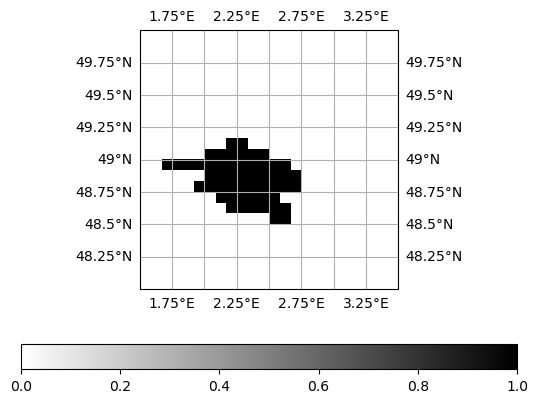

In [35]:
#-----------------------------------------------
# Draw city mask
#-----------------------------------------------

# city index
# [tokyo:1, losangels:12, paris: 20, london:29]
index = 20

mask_temp = np.fromfile(f'/home/kajiyama/H08/H08_20230612/map/dat/cty_msk_/city_{index:08d}.gl5', dtype='float32').reshape(2160, 4320)

# get city mask

# get city lonlat
lat_start, lat_end, lon_start, lon_end, latmin_gl5, latmax_gl5, lonmin_gl5, lonmax_gl5 = get_coordinate(index)

# crop
mask_flipped = np.flipud(mask_temp)
mask_cropped = mask_flipped[lat_start:lat_end, lon_start:lon_end]
cropped_flipped = np.flipud(mask_cropped)

# extent
projection = ccrs.PlateCarree()
img_extent = (lonmin_gl5, lonmax_gl5, latmin_gl5, latmax_gl5)

# figure
fig = plt.figure()
ax = plt.subplot(projection=projection)
ax.coastlines()
ax.gridlines(draw_labels=True)
im = ax.imshow(cropped_flipped,
               origin='upper',
               extent=img_extent,
               transform=projection,
               cmap='gray_r')
fig.colorbar(im, ax=ax, orientation='horizontal')